# Data Visualization
_________________________________________________________________________________

***#Hello =) So Here we'll need some more context. Why does a data scientist need to visualise and why is it important to have as many privacy-friendly tools as possible when doing that? Doesn't need to be massively long, 5/10 lines is enough. You can go check how they did it in the Kaggle Data Visualization tutorial to help yourself understand what I mean maybe.***

In this tutorial, we'll introduce the **data visualization functions** available in BastionLab and see **how to use them**.

## Pre-requisites
___________________________________________

### Technical requirements

>If you've done the [Quick Tour](https://bastionlab.readthedocs.io/en/latest/docs/quick-tour/quick-tour/), you can skip ahead to the Histplot section.

Else, we assume you have:
- Python3.7 or greater *(get the latest version of Python at [https://www.python.org/downloads/](https://www.python.org/downloads/) or with your operating system’s package manager)*
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager

### Getting set up

You'll need to download the **Titanic dataset** which is one of the most popular datasets used for understanding machine learning and contains information relating to the passengers aboard the Titanic.

You can run the following lines of code to download it *(or get the titanic.csv file from: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/data by creating a free account)*:

In [ ]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

Next, we'll install and launch the server. For testing purposes, BastionLab server has been packaged as a pip wheel. In this tutorial, we will use this package to quickly set up a test server.

In [ ]:
!pip install bastionlab_server

*You may alternatively install BastionLab Server using our Docker image or from source, refer to our more detailed [Installation Tutorial](../tutorials/installation.md).*

The server exposes port 50056 for gRPC communication with clients and uses a default configuration (no authentication, default settings). For the purpose of this tutorial, these settings are sufficient and we won't change them.

To run the server, we use the utility function provided by the bastionlab_server package.

In [ ]:
import bastionlab_server

srv = bastionlab_server.start()

Then, we'll install the necessary dependecies for this notebook - BastionLab and polars:

In [ ]:
! pip install polars
! pip install bastionlab

### Connecting to the remote dataset

>*In a typical workflow, the data owner would send a set of keys to the server, so that authorization can be required for all users at the point of connection. **BastionLab offers the authorization feature**, but as it's not the focus of this visualization tutorial, we will not use it. You can refer to the [authentication tutorial](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/authentication/) if you want to set it up.*

We'll connect to remote dataset by create an instance of `Connection()` and supplying the constructor with the host and port of our docker instance.

In [ ]:
from bastionlab import Connection

connection = Connection("localhost", 50056)
client = connection.client

Next, we get a Polars DataFrame instance of our csv file using Polars' `read_csv` function.

For the sake of this tutorial, we specify an **unsafe policy which disables all checks**. We set the `unsafe_zone` parameter to `TrueRule()` to allow all requests. In this case, the `unsafe_handling` parameter can be anything (as there are no unsafe requests), so we set it to `Log()` in the following example.

>**Important note** - This unsafe policy is used so that we can focus on demonstrating data visualization in BastionLab, without having to worry about approving any data access requests. However this policy is **not** suited for production.

Finally, we send the Polars' DataFrame instance to the server using Bastionlab's `polars.send_df()` method which will return a `RemoteLazyFrame` instance - which is a reference to the DataFrame uploaded. We will be working with it throughout this tutorial.

In [ ]:
import polars as pl
from bastionlab.polars.policy import Policy, TrueRule, Log

df = pl.read_csv("titanic.csv")
policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log())
rdf = client.polars.send_df(df, policy=policy)

rdf

FetchableLazyFrame(identifier=b1bdc5b3-79d4-4557-a804-a2c6b0f1f2d9)

Since we are using the classic Titanic dataset, let's list the columns to verify we got the right dataset and give you an idea of the data we will be handling in this tutorial.

In [ ]:
rdf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## Histplot
_____________________________________________________________________

Now, let's take a look at the first of our data visualization options, `histplot`.

The `histplot()` function accepts `x` and `y` arguments, which are strings referring to a column name, plus a `bins` integer value, which is set to 10 by default. You must provide either an `x` or `y` argument, the rest is optional. We also accept any `kwargs` arguments accepted by Seaborn's `barplot` function (this is possible because we call this function internally once we have ran the relevant aggregated query and applied bins to our dataframe). 

>Accepted options are listed in [Seaborn's barplot documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html).

Let's take a look at a simple example. Here, we create a histogram to show the number of passengers in each age category, with bins of 15.

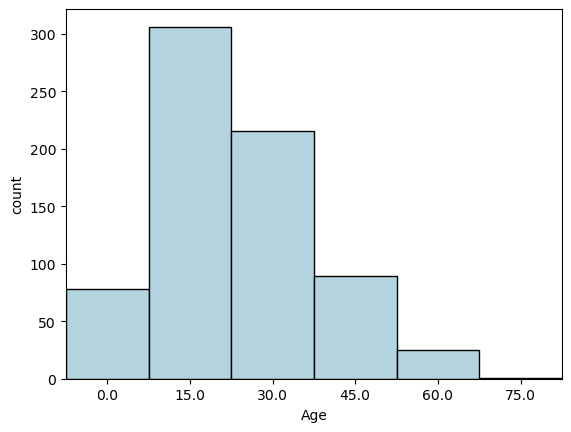

In [ ]:
rdf.histplot(x="Age", bins=15)

If we provide an `x` and `y` value, this will internally make use of Seaborn's `heatmap` function.

>Accepted options are listed in [Seaborn's heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

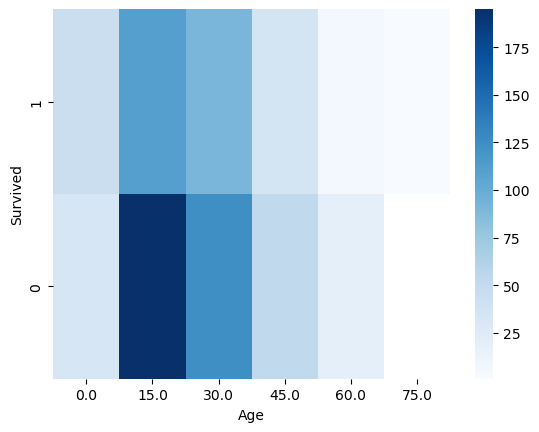

In [ ]:
rdf.histplot(x="Age", y="Survived", bins=15)

## Barplot
_____________________________________________________________________

The `barplot` function filters data down to necessary columns only, runs an aggregated query to get the mean (or other estimator function) `y` value for the `x` axes, and then calls Seaborn's barplot function to draw the barchart, forwarding on just this aggregated and filtered down dataset.

`barplot()` requires `x` and `y` values, which are strings referring to a column name. it also accepts an optional `estimator` string argument, where you can change the default estimator (`"mean"`) to any of the following estimators: `"mean"`, `"median"`, `"count"`, `"max"`, `"min"`, `"std"` and `"sum"`. There is also an optional `hue` argument where you can specify the name of a column you want to be used to group results by. We also accept any `kwargs` arguments accepted by Seaborn's barplot function. 

>Accepted options are listed in [Seaborn's barplot documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html).

Here, we create histogram to show the number of passengers in each age category, with bins of 15:

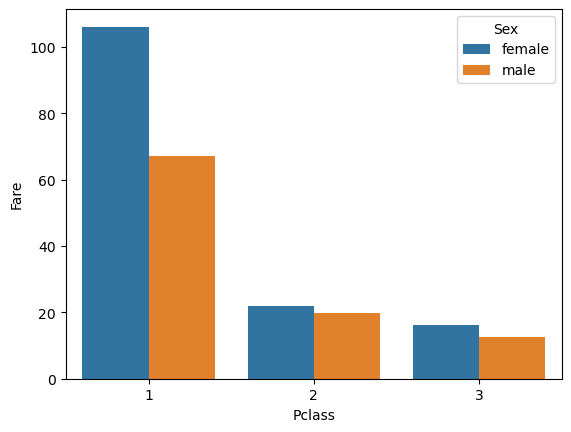

In [ ]:
rdf.barplot(x="Pclass", y="Fare", hue="Sex")

## Scatterplot
________________________________________________________________________________

The `scatterplot` function plot will display a scatter diagram based on x and y arguments which can be used to look for correlations between x and y columns. 

`scatterplot()` requires `x` and `y` string arguments referring to the name of the columns to be used for the x and y axes in the scatterplot. 

It will first narrow down the `RemoteLazyFrame` to the necessary columns to make the function call, before calling Seaborn's `scatterplot` function to plot your scattergraph.

This function also accepts the `optional arguments` of the Seaborn's scatterplot function as `kwargs`.

>You can find those in [Seaborn's scatterplot documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).

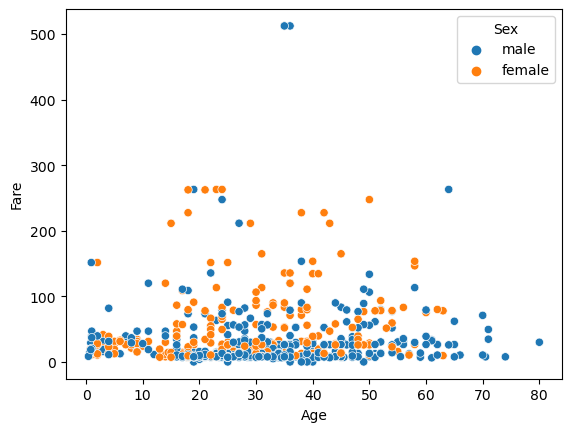

In [ ]:
rdf.scatterplot("Age", "Fare", hue="Sex")

## Lineplot
________________________________________________________________________________

The `lineplot` function filters our dataframe down to necessary columns only and then draws a lineplot using Seaborn's `lineplot` function.

`lineplot()` requires `x` and `y` string arguments that refer to the names of columns to be used for the x and y axes. 

It also accepts `hue`, `size` and `string` arguments which are the name of the columns to be used as grouping variables which will produce lines with different colors, widths and dashes and/or markers respectively. Additionnaly, it accepts a `units` argument - which is the name of a column to be used as a grouping variable identifying sampling units. ***#This is intense haha. Is there another way to say things in a bit more easy to read the sentence? Like you could make it two sentences to start with: "argument. It is the name of a column..." but it probably needs at least one more break =)*** Note that you must also set the `estimator` keyword to `None` if you wish to use the `units` argument.

Finally, the function accepts the `optional arguments` of Seaborn's `lineplot` function as `**kwargs`.

>You can find those in [Seaborn's lineplot documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html).

Let's have a look at an example.


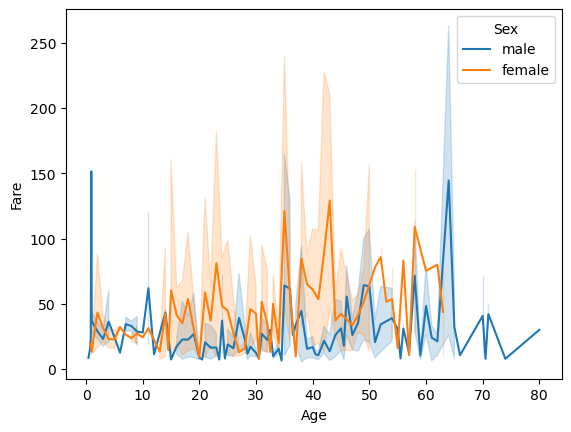

In [ ]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

## Pieplot
________________________________________________________________________________

The `pieplot` functions draws a pie chart where segmnet values are stored in one column and labels are provided. We calculate each individual cell in the column as a percentage of the sum of values in that column before calling [Matplotlib's `pie` function](***#ADD A LINK***). 

This is particularly useful after running aggregated queries, which will become clear in the following example, but first, let's take a look at the arguments `pieplot()` takes:

- An mandatory `parts` string argument, which is the name of the column containing the values for each segment in the pie chart.
- A `Title` string argument.
- A `labels` argument, which is either the name of the column containing labels values, or a List[str] of the labels. In both cases, the order of the labels should follow the same order as the values in the `parts` column.
- An `ax` argument, which allows you to send your own matplotlib axis if required. Note that if you do this, the following `fig_kwargs` arguments will not be used.
- A `fig_kwargs` dictionary argument, which is where you can add any `kwargs` you wish to be forwarded onto `matplotlib.pyplot.subplots()` when creating the figure that this piechart will be displayed on.
- A `pie_labels` boolean value, which you can modify to `False` if you do not with to label the segments of your pie chart.
- A `key` boolean value, where you can specify if you want a color map key placed to the side of your pie chart.
- The `key_loc`, `key_title` and `key_bbox` options, where you can specify the location, title and bbox options for your color map key. These are forwarded on to matplotlib's legend function.

Now, let's take a look at an example of where we might use `pieplot`. We will run an aggregated query to get the number of deceased per passenger class on the Titanic.

We first filter the dataset to those who did not survive the Titanic, then we select all necessary columns and group data by Pclass, before we get a count of values per each class and sort the output by `Pclass`.

We can then call our `pieplot` function on this dataset specifying the "Survived" column as our `parts` argument, a title for our pie chart and the `"Class"` column to be used for labelling, to get our pie chart.

shape: (3, 2)
┌────────┬──────────┐
│ Pclass ┆ Survived │
│ ---    ┆ ---      │
│ i64    ┆ u32      │
╞════════╪══════════╡
│ 1      ┆ 80       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 2      ┆ 97       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 3      ┆ 372      │
└────────┴──────────┘


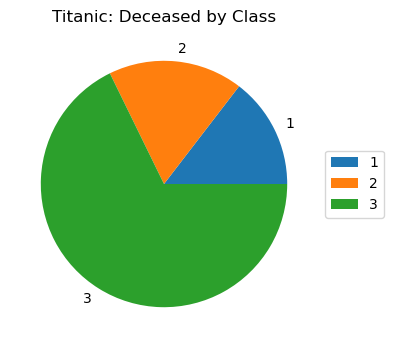

In [ ]:
rdf_ex = (
    rdf.filter(pl.col("Survived") == 0)
    .select([pl.col("Survived"), pl.col("Pclass")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").count())
    .sort(pl.col("Pclass"))
)
print(rdf_ex.collect().fetch())
rdf_ex.pieplot(parts="Survived", title="Titanic: Deceased by Class", labels="Pclass")

## Facet grid plots
_______________________________________________________________________________________________________________

The `facet` function lets you create a grid of plots that accepts a `col` and `row` argument. You can then call the `histplot`, `scatterplot` or `curveplot` functions to decide how you want to plot your data in the columns and rows of the grid. 

For example, if you have a facet with a row value of `"Pclass"` of class and you call `my_facet.histplot(x="Age", bins=15)`, you will see three histplots: one showing the age of passengers in class 1, one for passengers in class 2 and the final one for class 3.

Before we continue any further, let's see the code for this example:

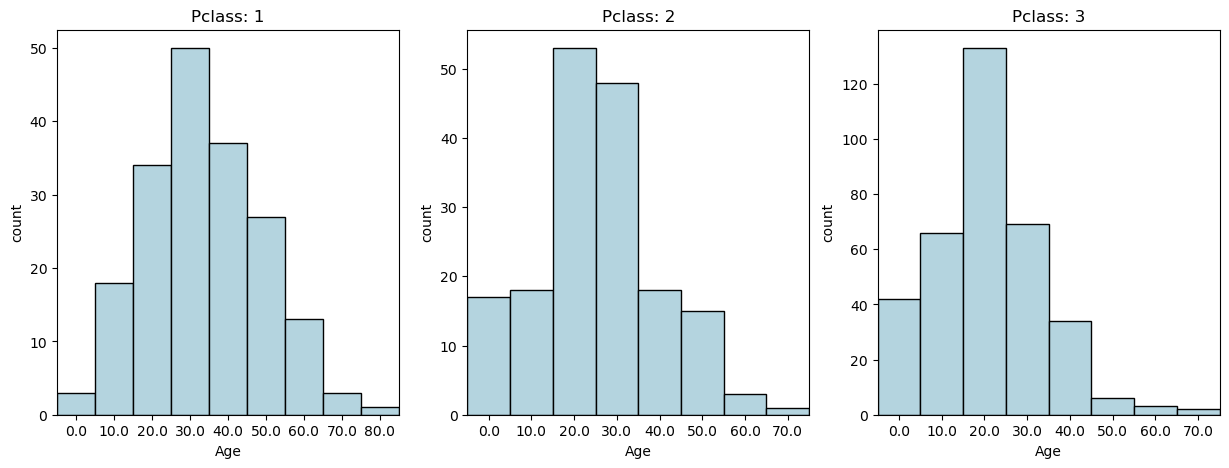

In [ ]:
my_facet = rdf.facet(col="Pclass")
my_facet.histplot(x="Age")

Now that we have seen an example with a row, let's add a column! We will also specify the `figsize`, the size of the figure we want for our grid.

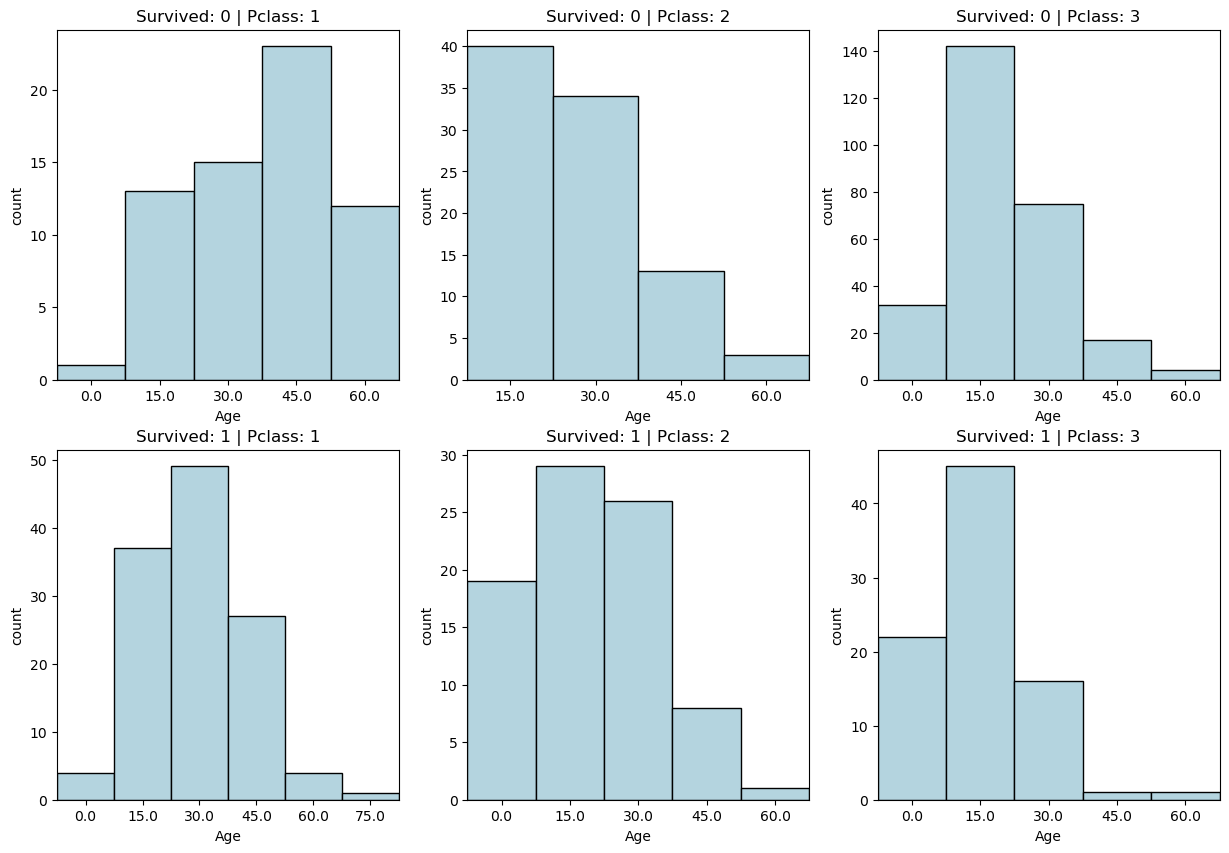

In [ ]:
new_facet = rdf.facet(col="Pclass", row="Survived", figsize=(15, 10))
new_facet.histplot(x="Age", bins=15)

The grid now splits results into all the possible combinations of the column and row values.

As previously mentioned, this feature works with all the visualization functions except for the pieplot function. 

>**Important note** - The `hue`, `size` `string` and `units` keywords are cannot be used for `lineplot` when using `facet`. 

Here's a facet grid with `scatterplot()`, for example:


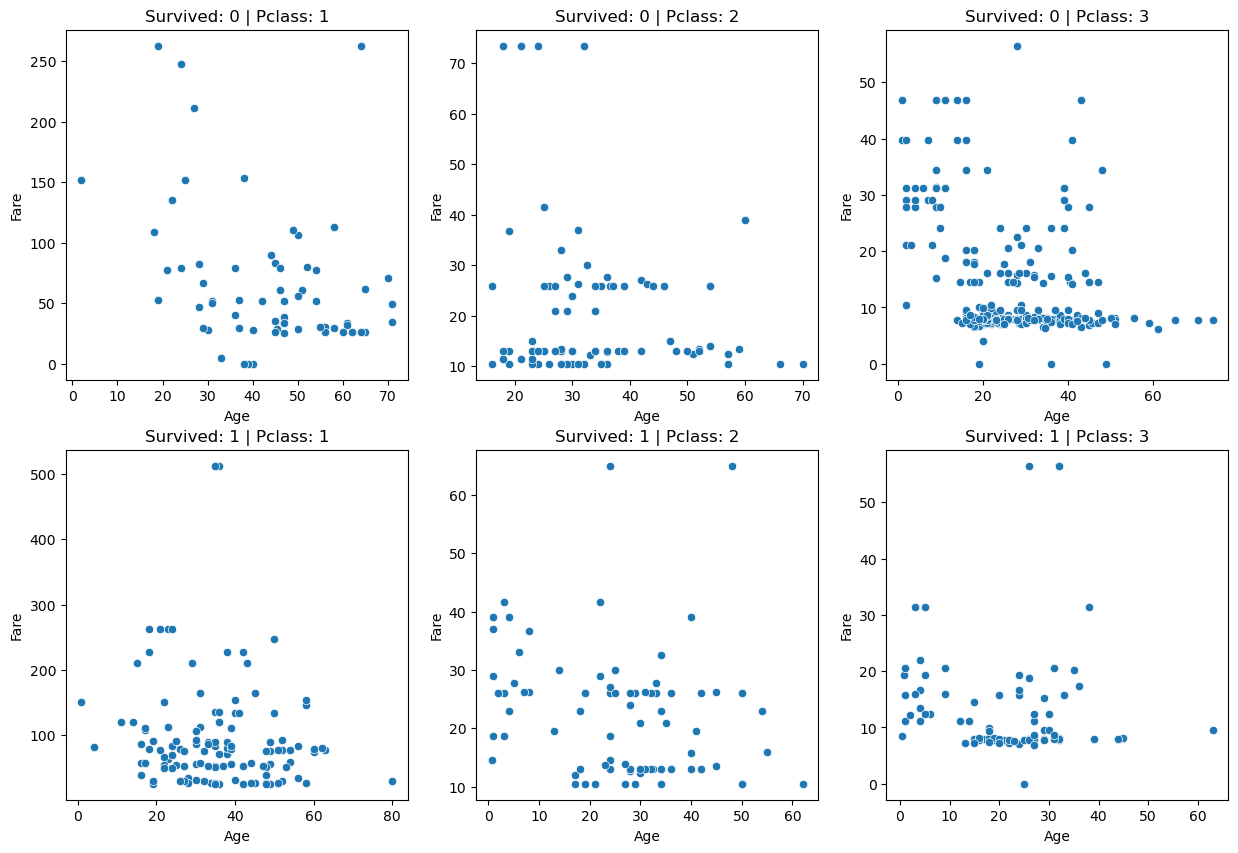

In [ ]:
new_facet = rdf.facet(col="Pclass", row="Survived")
new_facet.scatterplot(x="Age", y="Fare")

That's it! As our last step, we'll close the connection to the server.

In [ ]:
connection.close()